In [1]:
%matplotlib inline

In [2]:
from grale.all_nb import *

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [3]:
cosm = cosmology.Cosmology(0.7, 0.27, 0.0, 0.73)
cosmology.setDefaultCosmology(cosm)
D = cosm.getAngularDiameterDistance

zd = 0.5
zs1 = 1.2
zs2 = 1.8

src1Params = {
    "position": V(10, 5)*ANGLE_ARCSEC,
    "halfAxis": 1.1*ANGLE_ARCSEC,
    "eccentricity": 0.6,
    "angle": 30,
}
src2Params = {
    "position": V(2, -4.5)*ANGLE_ARCSEC,
    "halfAxis": 1.0*ANGLE_ARCSEC,
    "eccentricity": 0.4,
    "angle": 110,
}


In [4]:
l = lenses.NSIELens(D(zd), { "velocityDispersion": 1300000, "ellipticity": 0.8, "coreRadius": 1.5*ANGLE_ARCSEC })
li = plotutil.LensInfo(l, size=80*ANGLE_ARCSEC, zd=zd, numxy=1023)

Text(value='')

FloatProgress(value=0.0)

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

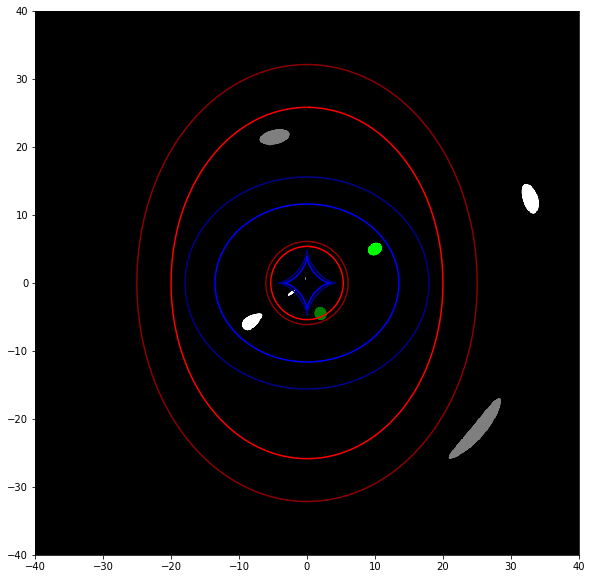

In [5]:
plt.figure(figsize=(10, 10))
plotutil.plotImagePlane(li, [
    { "shape": images.EllipticalSource(**src1Params), "z": zs1 },
    { "shape": images.EllipticalSource(**src2Params), "z": zs2 } ],
    sourceRgb = [ (0,1,0), (0,0.5,0) ],
    imageRgb = [ (1,1,1), (0.5,0.5,0.5) ],
    caustColor = [ "blue", "darkblue" ],
    critColor = [ "red", "darkred" ]
)

In [6]:
li.setSourceRedshift(zs1)
ip = li.getImagePlane()
src1ImagePixels = ip.segment(ip.renderImages([images.EllipticalSource(**src1Params)]))

li.setSourceRedshift(zs2)
ip = li.getImagePlane()
src2ImagePixels = ip.segment(ip.renderImages([images.EllipticalSource(**src2Params)]))

Text(value='')

Text(value='')

In [7]:
def pixelsToImagesData(pix):
    imgDat = images.ImagesData(len(pix))
    for i, img in zip(range(len(pix)), pix):
        for p in img:
            imgDat.addPoint(i, p)
    return imgDat

In [8]:
imgDat1 = pixelsToImagesData(src1ImagePixels)
imgDat2 = pixelsToImagesData(src2ImagePixels)

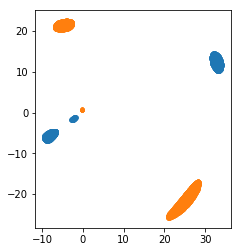

In [9]:
plotutil.plotImagesData([imgDat1, imgDat2])
plt.gca().set_aspect("equal")

In [10]:
def findMaxRadius(ctr, imgDat):
    maxDist = 0
    for i in range(imgDat.getNumberOfImages()):
        for p in range(imgDat.getNumberOfImagePoints(i)):
            pt = imgDat.getImagePointPosition(i, p)
            diff = pt-ctr
            dist = diff[0]**2 + diff[1]**2
            if dist > maxDist:
                maxDist = dist
            
    return maxDist**0.5
    
def findAnnuli(ctr, imagesAndRedshifts, zd, cosm, numBins, maxRadiusFactor):
    import math
    
    maxRadius = max([findMaxRadius(ctr, i["imgdata"]) for i in imagesAndRedshifts])
    maxRadius *= maxRadiusFactor
    
    sourceNumber = [ None for _ in range(numBins) ]
    radialStep = maxRadius/(numBins-1)
    
    Dd = cosm.getAngularDiameterDistance(zd)
    criticalDensities = []
    totalImages = 0
    
    for iz, srcIdx in zip(imagesAndRedshifts, range(len(imagesAndRedshifts))):
        imgDat, zs = iz["imgdata"], iz["z"]
        
        Ds = cosm.getAngularDiameterDistance(zs)
        Dds = cosm.getAngularDiameterDistance(zd, zs)
        criticalDensities.append(lenses.getCriticalDensity(Dd, Ds, Dds))
        
        for i in range(imgDat.getNumberOfImages()):
            totalImages += 1
            minDist, maxDist = float("inf"), 0
            
            for p in range(imgDat.getNumberOfImagePoints(i)):
                diff = imgDat.getImagePointPosition(i, p) - ctr
                dist = diff[0]**2 + diff[1]**2
                minDist = min(dist, minDist)
                maxDist = max(dist, maxDist)
                
            minDist = minDist**0.5
            maxDist = maxDist**0.5
            
            minIdx = max(math.floor(minDist/radialStep) - 1, 0)
            maxIdx = min(math.ceil(maxDist/radialStep) + 1, numBins-1)
            
            for p in range(minIdx, maxIdx+1):
                if not (sourceNumber[p] is None or sourceNumber[p] == srcIdx):
                    raise Exception("Overlapping image annuli, can't construct degeneracy")
            
                sourceNumber[p] = srcIdx
    
    startRadii, endRadii, criticalMasses = [], [], []
    index = 0
    while True:
        
        # Look for start of next image annulus
        while index < numBins and sourceNumber[index] is None:
            index += 1
        
        if index >= numBins:
            break
            
        #print("Index is", index)
            
        curSrc = sourceNumber[index]
        startRadii.append(radialStep * index)
        criticalMasses.append(criticalDensities[curSrc])
        
        # Look for end of image
        while sourceNumber[index] == curSrc and index < numBins:
            # We need to set this to None, otherwise the previous while loop
            # might fail if regions touch each other
            sourceNumber[index] = None
            index += 1
            
        index -= 1
        #print("End index is", index)
        
        endRadii.append(index*radialStep)
        
        if index >= numBins-1:
            break
            
    return maxRadius, startRadii, endRadii, criticalMasses
            
def createGeneralizedMassSheet(ctr, imagesAndRedshifts, zd, cosm, numBins = 100000, maxRadiusFactor = 1.01):
    import math

    Dd = cosm.getAngularDiameterDistance(zd)
    radius, startRadii,  endRadii, criticalMasses = findAnnuli(ctr, imagesAndRedshifts, zd, cosm, numBins, maxRadiusFactor)
    
    numAnnuli = len(startRadii)
    params = []
    for i in range(numAnnuli):
        
        if i == 0: # first part
            params.append({
                "xoffset": 0,
                "yoffset": 0,
                "xscale": endRadii[i],
                "yscale": math.pi*Dd*Dd*criticalMasses[i]*endRadii[i]*endRadii[i],
                "xend": endRadii[i],
                "coeffs": [0, 0, 1]
            })
        else:
            # Interpolated part
            startRadius = endRadii[i-1]
            endRadius = startRadii[i]
            startMass = math.pi*Dd*Dd*startRadius*startRadius*criticalMasses[i-1]
            endMass =  math.pi*Dd*Dd*endRadius*endRadius*criticalMasses[i]
            startSlope = 2.0*math.pi*Dd*Dd*startRadius*criticalMasses[i-1]
            endSlope = 2.0*math.pi*Dd*Dd*endRadius*criticalMasses[i]

            height = endMass-startMass
            width = endRadius-startRadius

            scaledStartSlope = startSlope*width/height
            scaledEndSlope = endSlope*width/height

            params.append({
                "xoffset": startRadius,
                "yoffset": startMass,
                "xscale": width,
                "yscale": height,
                "xend": endRadius,
                "coeffs": [ 0, scaledStartSlope, 
                            3.0 - 2.0*scaledStartSlope-scaledEndSlope, -2.0 + scaledStartSlope + scaledEndSlope ]
            })
            
            # Constrained part
            width = endRadii[i]-startRadii[i];

            params.append({
                "xoffset": startRadii[i],
                "yoffset": math.pi*Dd*Dd*criticalMasses[i]*startRadii[i]*startRadii[i],
                "xscale": width,
                "yscale": math.pi*Dd*Dd*criticalMasses[i]*width*width,
                "xend": endRadii[i],
                "coeffs": [ 0, 2.0*startRadii[i]/width, 1]
            })
            
    if numAnnuli > 0: # finish profile
        
        startRadius = endRadii[numAnnuli-1]
        endRadius = radius
        startMass = math.pi*Dd*Dd*startRadius*startRadius*criticalMasses[numAnnuli-1]
        startSlope = 2.0*math.pi*Dd*Dd*startRadius*criticalMasses[numAnnuli-1]
        endSlope = 0

        width = endRadius-startRadius
        height = 0.5*width*startSlope;

        scaledStartSlope = startSlope*width/height;

        params.append({
            "xoffset": startRadius,
            "yoffset": startMass,
            "xscale": width,
            "yscale": height,
            "xend": endRadius,
            "coeffs": [ 0, scaledStartSlope, -0.5*scaledStartSlope ]
        })
        
    return lenses.PolynomialMassProfileLens(Dd, params)


In [11]:
ctr = V(0, -5)*ANGLE_ARCSEC
gen = createGeneralizedMassSheet(ctr, [
    { "imgdata": imgDat1, "z": zs1 },
    { "imgdata": imgDat2, "z": zs2 }], zd, cosm)

In [12]:
thetas = np.linspace(0, 40, 256)*ANGLE_ARCSEC
enclosedMass = gen.getRadialMassProfile(thetas)
density = gen.getRadialDensityProfile(thetas)

In [13]:
imgThetasCentered = np.array([ np.sum((p["position"] - ctr)**2, 0)**0.5 for imgDat in [ imgDat1, imgDat2] for img in imgDat.getAllImagePoints() for p in img ])
enclosedMassAtImages = gen.getRadialMassProfile(imgThetasCentered)

In [14]:
critDens = [ l.getCriticalDensity(D(z), D(zd,z)) for z in [zs1, zs2]]

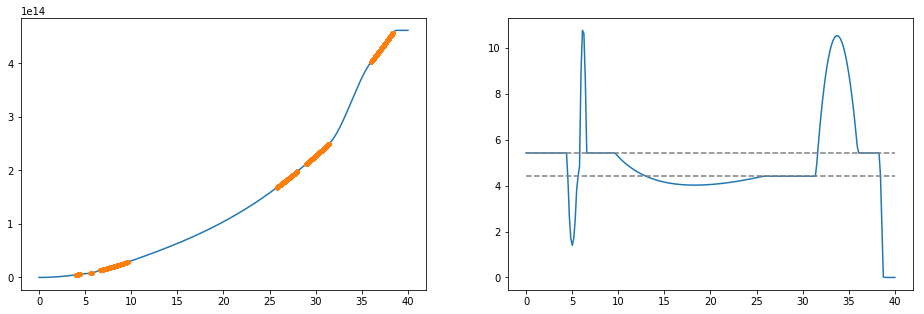

In [15]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(thetas/ANGLE_ARCSEC, enclosedMass/MASS_SUN)
plt.plot(imgThetasCentered/ANGLE_ARCSEC, enclosedMassAtImages/MASS_SUN, '.')
plt.subplot(1,2,2)
plt.plot(thetas/ANGLE_ARCSEC, density)
plt.plot([0,40],[critDens[0], critDens[0]], "--", color="gray")
plt.plot([0,40],[critDens[1], critDens[1]], "--", color="gray")

In [16]:
lambd = 0.75
degen = lenses.CompositeLens(D(zd), [
    { "lens": l, "factor": lambd, "x": 0, "y": 0, "angle": 0 },
    { "lens": gen, "factor": (1-lambd), "x": ctr[0], "y": ctr[1], "angle": 0}
])

dli = plotutil.LensInfo(degen, size=80*ANGLE_ARCSEC, zd=zd, numxy=1023)

Text(value='')

FloatProgress(value=0.0)

Text(value='')

FloatProgress(value=0.0)

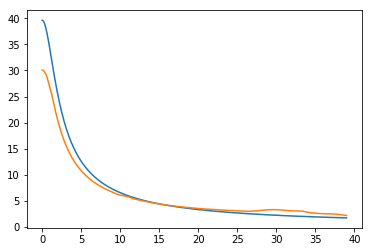

In [17]:
plotutil.plotAverageDensityProfile(li, 39*ANGLE_ARCSEC);
plotutil.plotAverageDensityProfile(dli, 39*ANGLE_ARCSEC);

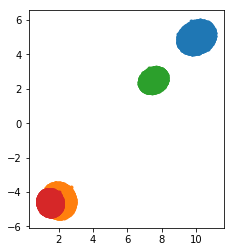

In [18]:
iws = inversion.InversionWorkSpace(zd, 80*ANGLE_ARCSEC)
iws.addImageDataToList(imgDat1, zs1, "extendedimages")
iws.addImageDataToList(imgDat2, zs2, "extendedimages")

plotutil.plotImagesData(iws.backProject(l))
plotutil.plotImagesData(iws.backProject(degen))
plt.gca().set_aspect("equal")